# Task 5 & 6: OTD-Aware Demand-to-Sales Simulator

This notebook extends the Task 4 daily demand simulator with **Order-to-Delivery (OTD)** sensitivity modeling to convert **demand → sales**.

## Key extensions:

### Task 1.5: OTD-to-Sales Conversion
- Accept OTD scenario inputs (metro/non-metro delivery times by country/year)
- Model customer purchase probability as a function of OTD promise
- Transform daily demand → daily sales predictions based on OTD sensitivity

### Task 1.6: Scenario Analysis
- Generate multiple OTD scenario configurations
- Compare daily sales under different OTD offerings
- Visualize: heatmaps, boxplots, time-series comparisons

## OTD Probability Table (from PDF page 3):

| OTD Range | Metro Conversion | Non-Metro Conversion |
|-----------|-----------------|---------------------|
| 0 days (same-day) | 100% | 100% |
| 1 day | 95% | 99.5% |
| 2 days | 85% | 98% |
| 3-4 days | 65% | 90% |
| 5-7 days | 40% | 70% |
| 8-15 days | 20% | 30% |
| 16-30 days | 10% | 15% |
| 31-60 days | 5% | 7.5% |

## Modified Pipeline Logic:

**Key difference from Task 4**: OTD conversion is applied at the **aggregate demand level** per segment (metro/non-metro) per day, THEN decomposed to product models. This avoids over-multiplication and keeps output size manageable.

1. Generate daily **aggregate demand** by segment (metro/non-metro/country/city)
2. Apply **OTD conversion** to aggregate demand → **aggregate sales**
3. Decompose aggregate sales to **24 product models** using triangular model shares
4. Run multiple OTD scenarios and compare results

## 1. Setup & Imports

In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import matplotlib.dates as mdates
import seaborn as sns
from datetime import date, timedelta
import warnings
warnings.filterwarnings('ignore')

np.random.seed(42)

## 2. Population Data from 1.1_Ty.xlsx

Metro cities and 2026 populations are extracted directly from the file. Country growth rates are applied to project forward. Non-metro population = country overall − sum of metro cities.

In [2]:
import openpyxl

wb = openpyxl.load_workbook('1.1_Ty.xlsx', data_only=True)
country_sheet = wb['Country']
city_sheet = wb['City']

metro_rows = []
country_stats = {}

# Extract country statistics
for row in country_sheet.iter_rows(min_row=2, values_only=True):
    stat_country, metro_stat, nonmetro_stat, overall_stat, gr = row[0], row[1], row[2], row[3], row[4]
    if isinstance(stat_country, str) and isinstance(overall_stat, (int, float)) and gr is not None:
        country_stats[stat_country] = {
            'metro_pop_2026': metro_stat,
            'nonmetro_pop_2026': nonmetro_stat,
            'overall_pop_2026': overall_stat,
            'growth_rate': gr
        }

# Extract metro cities
current_country = None
for row in city_sheet.iter_rows(values_only=True):
    country_col, city_col, pop_col = row[0], row[1], row[2]
    if isinstance(country_col, str):
        current_country = country_col
    if current_country and isinstance(city_col, str) and isinstance(pop_col, (int, float)):
        metro_rows.append({'Country': current_country, 'City': city_col, 'Pop_2026': int(pop_col)})

metro_df = pd.DataFrame(metro_rows)
country_stats_df = pd.DataFrame(country_stats).T.reset_index().rename(columns={'index': 'Country'})
country_stats_df[['metro_pop_2026', 'nonmetro_pop_2026', 'overall_pop_2026', 'growth_rate']] = \
    country_stats_df[['metro_pop_2026', 'nonmetro_pop_2026', 'overall_pop_2026', 'growth_rate']].apply(pd.to_numeric)

print(f'Metro cities: {len(metro_df)}')
print(f'Countries with stats: {len(country_stats_df)}')
metro_df.head(10)

Metro cities: 273
Countries with stats: 29


,Country,City,Pop_2026
0,Belgium,Brussels,2150320
1,Belgium,Antwerp,1068660
2,Belgium,Liege,690769
3,Belgium,Gent,480931
4,Belgium,Charleroi,420510
5,Germany,Berlin,3584240
6,Germany,Hamburg,1788890
7,Germany,Munich,1596050
8,Germany,Koeln,963395
9,Germany,Frankfurt am Main,650000


In [3]:
# Project populations 2027-2034
YEARS = list(range(2027, 2035))

# Metro projections
metro_df = metro_df.merge(country_stats_df[['Country', 'growth_rate']], on='Country', how='left')
for yr in YEARS:
    n = yr - 2026
    metro_df[f'Pop_{yr}'] = (metro_df['Pop_2026'] * (1 + metro_df['growth_rate'])**n).round(0).astype(int)

# Non-metro projections
metro_sum = metro_df.groupby('Country')[[f'Pop_{yr}' for yr in YEARS]].sum().reset_index()
metro_sum = metro_sum.rename(columns={f'Pop_{yr}': f'MetroSum_{yr}' for yr in YEARS})

nonmetro_df = country_stats_df.copy()
for yr in YEARS:
    n = yr - 2026
    nonmetro_df[f'OverallPop_{yr}'] = (nonmetro_df['overall_pop_2026'] * (1 + nonmetro_df['growth_rate'])**n).round(0)

nonmetro_df = nonmetro_df.merge(metro_sum, on='Country', how='left')
for yr in YEARS:
    nonmetro_df[f'NonMetroPop_{yr}'] = (nonmetro_df[f'OverallPop_{yr}'] - nonmetro_df[f'MetroSum_{yr}']).clip(lower=0).round(0)

print('Metro (first 5):')
print(metro_df[['Country', 'City', 'Pop_2026', 'Pop_2027', 'Pop_2028']].head())
print('\nNon-Metro (first 5):')
print(nonmetro_df[['Country', 'NonMetroPop_2027', 'NonMetroPop_2028']].head())

Metro (first 5):
   Country       City  Pop_2026  Pop_2027  Pop_2028
0  Belgium   Brussels   2150320   2153330   2156345
1  Belgium    Antwerp   1068660   1070156   1071654
2  Belgium      Liege    690769    691736    692705
3  Belgium       Gent    480931    481604    482279
4  Belgium  Charleroi    420510    421099    421688

Non-Metro (first 5):
       Country  NonMetroPop_2027  NonMetroPop_2028
0      Belgium         6973159.0         6982921.0
1      Germany        58518166.0        58219725.0
2  Netherlands        14010356.0        14210705.0
3      Denmark         4400797.0         4425440.0
4      Estonia          875401.0          878464.0


In [4]:
# save for task4 reading

metro_df.to_excel( '../Task4/Pop_inputs.xlsx', sheet_name = 'Metro', index=False)
nonmetro_df.to_excel( '../Task4/Pop_inputs.xlsx', sheet_name = 'NonMetro', index=False)

## 3. Demand Parameters (from Task 4)

In [4]:
# Market entry years
ENTRY_YEAR = {
    'Belgium': 2027, 'Germany': 2027, 'Luxembourg': 2027, 'Netherlands': 2027,
    'Denmark': 2028, 'Estonia': 2028, 'Finland': 2028, 'Latvia': 2028,
    'Lithuania': 2028, 'Norway': 2028, 'Poland': 2028, 'Sweden': 2028,
    'Austria': 2029, 'France': 2029, 'Ireland': 2029, 'Italy': 2029,
    'Portugal': 2029, 'Spain': 2029, 'Switzerland': 2029,
    'Bulgaria': 2030, 'Croatia': 2030, 'Cyprus': 2030, 'Czech Republic': 2030,
    'Greece': 2030, 'Hungary': 2030, 'Malta': 2030, 'Romania': 2030,
    'Slovakia': 2030, 'Slovenia': 2030
}

# Adoption rate functions (triangular basis)
def adoption_rate_mp(market_year: int) -> float:
    if market_year <= 0: return 0.0
    base = 0.00025
    if market_year == 1: return base
    base += 0.0002
    if market_year == 2: return base
    base += 0.0001
    if market_year == 3: return base
    return base + (market_year - 3) * 0.00005

def adoption_rate_opt(market_year: int) -> float:
    if market_year <= 0: return 0.0
    base = 0.0005
    if market_year == 1: return base
    base += 0.00025
    if market_year == 2: return base
    base += 0.0002
    if market_year == 3: return base
    return base + (market_year - 3) * 0.0001

def adoption_rate_pes(market_year: int) -> float:
    if market_year <= 0: return 0.0
    base = 0.0002
    if market_year == 1: return base
    base += 0.0001
    if market_year == 2: return base
    base += 0.00005
    if market_year == 3: return base
    return max(0, base + (market_year - 3) * (-0.00002))

# Day-of-week and period parameters
DOW_WEIGHTS = np.array([0.12, 0.12, 0.23, 0.25, 0.15, 0.10, 0.03])  # Mon-Sun
PERIOD_SHARES_BASE = np.array([0.05, 0.07, 0.09, 0.09, 0.09, 0.05, 0.04,
                                0.06, 0.13, 0.09, 0.06, 0.07, 0.11])
PERIOD_CV = 0.25
CYBER_WEEK_SHARE = 0.15
CYBER_PRICE_DISCOUNT = 0.15

print('Adoption rates loaded')
print(f'Year 1 MP: {adoption_rate_mp(1)*100:.4f}%')
print(f'Year 4 MP: {adoption_rate_mp(4)*100:.4f}%')

Adoption rates loaded
Year 1 MP: 0.0250%
Year 4 MP: 0.0600%


In [5]:
# MyBot models
MODELS = [
    ('F10', 'Floor Care', 10, 360, 0.17),
    ('K10', 'Kitchen Help', 10, 360, 0.13),
    ('S10', 'Safety & Security', 10, 360, 0.10),
    ('W10', 'Wall & Window', 10, 360, 0.09),
    ('F20', 'Floor Care', 20, 480, 0.08),
    ('K20', 'Kitchen Help', 20, 480, 0.06),
    ('L20', 'Leisure', 20, 480, 0.05),
    ('S20', 'Safety & Security', 20, 480, 0.05),
    ('W20', 'Wall & Window', 20, 480, 0.04),
    ('X20', 'Exterior Care', 20, 480, 0.04),
    ('F30', 'Floor Care', 30, 600, 0.04),
    ('K30', 'Kitchen Help', 30, 600, 0.03),
    ('L30', 'Leisure', 30, 600, 0.03),
    ('S30', 'Safety & Security', 30, 600, 0.03),
    ('W30', 'Wall & Window', 30, 600, 0.02),
    ('X30', 'Exterior Care', 30, 600, 0.02),
    ('F50', 'Floor Care', 50, 720, 0.02),
    ('K50', 'Kitchen Help', 50, 720, 0.02),
    ('L50', 'Leisure', 50, 720, 0.01),
    ('S50', 'Safety & Security', 50, 720, 0.01),
    ('W50', 'Wall & Window', 50, 720, 0.01),
    ('X50', 'Exterior Care', 50, 720, 0.01),
    ('L10', 'Leisure', 10, 360, 0.02),
    ('X10', 'Exterior Care', 10, 360, 0.02),
]

model_df = pd.DataFrame(MODELS, columns=['Model', 'Category', 'Level', 'Price_EUR', 'Share_MP'])
model_df['Share_MP'] = model_df['Share_MP'] / model_df['Share_MP'].sum()

print(f'Loaded {len(model_df)} MyBot models')
print(f'Total model share: {model_df["Share_MP"].sum():.6f}')

Loaded 24 MyBot models
Total model share: 1.000000


## 4. Calendar & Cyber Week Helper Functions

In [6]:
def first_monday_of_year(year: int) -> date:
    d = date(year, 1, 1)
    days_ahead = (7 - d.weekday()) % 7
    if days_ahead == 0:
        return d
    return d + timedelta(days=days_ahead) # add a date to move the date on calendar forwards

def black_friday(year: int) -> date:
    nov1 = date(year, 11, 1)
    days_to_friday = (4 - nov1.weekday()) % 7
    first_fri = nov1 + timedelta(days=days_to_friday)
    return first_fri + timedelta(weeks=3)

def cyber_week_dates(year: int):
    bf = black_friday(year)
    return {bf + timedelta(days=d) for d in range(4)}

def build_year_calendar(year: int) -> pd.DataFrame:
    start = date(year, 1, 1)
    end = date(year, 12, 31)
    days = [start + timedelta(days=i) for i in range((end - start).days + 1)]
    
    period_start = first_monday_of_year(year)
    cw = cyber_week_dates(year)
    
    records = []
    for d in days:
        delta = (d - period_start).days
        if delta >= 0:
            period = delta // 28 + 1
            period = min(period, 13)
        else:
            period = 1
        records.append({
            'date': d,
            'year': year,
            'day_of_week': d.weekday(),
            'period': period,
            'is_cyber_week': d in cw # returns boolean variable
        })
    return pd.DataFrame(records)

print(f'Black Friday 2027: {black_friday(2027)}')
print(f'Cyber Week 2027: {sorted(cyber_week_dates(2027))}')

Black Friday 2027: 2027-11-26
Cyber Week 2027: [datetime.date(2027, 11, 26), datetime.date(2027, 11, 27), datetime.date(2027, 11, 28), datetime.date(2027, 11, 29)]


## 5. OTD Probability Table & Conversion Functions

In [7]:
# OTD probability lookup table from PDF page 3 (INTERVAL-BASED FORMAT)
OTD_PROB_TABLE = {
    'Metro': [
        (0, 0, 1.00),      # same-day
        (1, 1, 0.95),      # 1 day
        (2, 2, 0.85),      # 2 days
        (3, 4, 0.65),      # 3-4 days
        (5, 7, 0.40),      # 5-7 days
        (8, 15, 0.20),     # 8-15 days
        (16, 30, 0.10),    # 16-30 days
        (31, 60, 0.05),    # 31-60 days
    ],
    'Non-Metro': [
        (0, 0, 1.00),
        (1, 1, 0.995),
        (2, 2, 0.98),
        (3, 4, 0.90),
        (5, 7, 0.70),
        (8, 15, 0.30),
        (16, 30, 0.15),
        (31, 60, 0.075),
    ]
}

def get_otd_conversion_rate(segment: str, otd_days: float) -> float:
    """Get conversion rate using interval-based lookup with interpolation."""
    table = OTD_PROB_TABLE[segment]
    
    # Find matching interval
    for min_days, max_days, conv_rate in table:
        if min_days <= otd_days <= max_days:
            return conv_rate
    
    # Out of range cases
    if otd_days < table[0][0]:
        return table[0][2]
    if otd_days > table[-1][1]:
        return table[-1][2]
    
    # Between intervals: interpolate
    for i in range(len(table) - 1):
        min1, max1, rate1 = table[i]
        min2, max2, rate2 = table[i + 1]
        mid1 = (min1 + max1) / 2.0
        mid2 = (min2 + max2) / 2.0
        if max1 < otd_days < min2:
            t = (otd_days - mid1) / (mid2 - mid1)
            return rate1 + t * (rate2 - rate1)
    
    return 0.0

print('Interval-based OTD table loaded')
print(f'Metro 2-day: {get_otd_conversion_rate("Metro", 2):.1%}')
print(f'Non-Metro 5-day: {get_otd_conversion_rate("Non-Metro", 5):.1%}')

Interval-based OTD table loaded
Metro 2-day: 85.0%
Non-Metro 5-day: 70.0%


## 6. Stochastic Helper Functions

In [8]:
def triangular_adoption_rate(market_year: int, sim: int, yr: int) -> float:
    """
    Draw annual adoption rate from Triangular distribution.
    Fresh seed per (year, sim) for independent draws.
    """
    a = adoption_rate_pes(market_year)
    c = adoption_rate_mp(market_year)
    b = adoption_rate_opt(market_year)
    
    if a >= b:
        return c
    c = np.clip(c, a + 1e-12, b - 1e-12)
    
    seed = int(yr) * 100_000 + int(sim) * 13
    rng = np.random.default_rng(seed)
    return float(rng.triangular(left=a, mode=c, right=b))

def triangular_model_shares(model_shares_base: np.ndarray, sim: int, yr: int, spread: float = 0.20) -> np.ndarray:
    """
    Draw 24-model share vector from Triangular distribution.
    Renormalized to sum=1.
    """
    a = model_shares_base * (1.0 - spread)
    c = model_shares_base
    b = model_shares_base * (1.0 + spread)
    
    seed = int(yr) * 100_000 + int(sim) * 13 + 7
    rng = np.random.default_rng(seed)
    
    draws = rng.triangular(left=a, mode=c, right=b)
    draws = np.clip(draws, 1e-9, None)
    return draws / draws.sum()

def simulate_period_shares(n_sim: int = 1, seed: int = None) -> np.ndarray:
    """
    Draw period shares from Normal(base, CV*base).
    Returns shape (n_sim, 13).
    """
    rng = np.random.default_rng(seed)
    mu = PERIOD_SHARES_BASE
    std = PERIOD_CV * mu
    draws = rng.normal(loc=mu, scale=std, size=(n_sim, 13))
    draws = np.clip(draws, 1e-6, None)
    return draws / draws.sum(axis=1, keepdims=True)

print('Stochastic functions defined')

Stochastic functions defined


## 7. Core Simulator — Aggregate Demand with OTD Conversion

### Modified pipeline:
1. Compute annual demand by segment (metro/non-metro) using triangular adoption rates
2. Allocate to daily **aggregate demand** by segment, day, and Cyber Week status
3. **Apply OTD conversion** at aggregate level → **aggregate sales**
4. Decompose aggregate sales to 24 products using triangular model shares

This avoids the explosion in output size from applying conversion at product level.

In [9]:
def run_otd_simulator(
    metro_df: pd.DataFrame,
    nonmetro_df: pd.DataFrame,
    model_df: pd.DataFrame,
    entry_year_map: dict,
    years: list,
    metro_city_otd: dict,  # City-level OTD: {city_name: otd_days}
    nonmetro_otd,    # Single value for non-metro
    n_sim: int = 1,
    seed: int = 42
) -> pd.DataFrame:
    """
    Run OTD simulator with CITY-LEVEL metro OTD specification.
    
    Args:
        metro_city_otd: Dict mapping city names to OTD days (e.g., {'Brussels': 1.0, 'Berlin': 1.5})
        nonmetro_otd: Single OTD value for all non-metro areas
    """
    rng_global = np.random.default_rng(seed)
    model_shares_base = model_df['Share_MP'].values
    model_codes = model_df['Model'].values
    model_prices = model_df['Price_EUR'].values
    
    sim_records = []
    
    for sim in range(n_sim):
        print(f'  Sim {sim+1}/{n_sim}...', end=' ', flush=True)
        
        for yr in years:
            cal = build_year_calendar(yr)
            cw_days = cal[cal['is_cyber_week']]['date'].values
            ncw_days = cal[~cal['is_cyber_week']]
            n_cw = len(cw_days)
            
            # ── 1. Compute annual demand AGGREGATED BY COUNTRY-SEGMENT ──
            segment_annual = {}
            
            # Metro cities - aggregate to country level
            for _, city_row in metro_df.iterrows():
                country = city_row['Country']
                if country not in entry_year_map:
                    continue
                entry = entry_year_map[country]
                market_year = yr - entry + 1
                if market_year < 1:
                    continue
                
                pop = city_row[f'Pop_{yr}']
                rate = triangular_adoption_rate(market_year, sim, yr)
                units = pop * rate
                
                key = (country, 'Metro')
                segment_annual[key] = segment_annual.get(key, 0) + units
            
            # Non-metro
            for _, nm_row in nonmetro_df.iterrows():
                country = nm_row['Country']
                if country not in entry_year_map:
                    continue
                entry = entry_year_map[country]
                market_year = yr - entry + 1
                if market_year < 1:
                    continue
                
                pop = nm_row[f'NonMetroPop_{yr}']
                rate = triangular_adoption_rate(market_year, sim, yr)
                units = pop * rate
                
                key = (country, 'Non-Metro')
                segment_annual[key] = units
            
            if len(segment_annual) == 0:
                continue
            
            total_annual = sum(segment_annual.values())
            if total_annual == 0:
                continue
            
            # ── 2. Draw period shares ──
            period_shares = simulate_period_shares(n_sim=1, seed=int(rng_global.integers(0, 1_000_000)))[0]
            
            # ── 3. Split: Cyber Week vs regular ──
            cyber_total = total_annual * CYBER_WEEK_SHARE
            regular_total = total_annual * (1.0 - CYBER_WEEK_SHARE)
            
            # ── 4. Allocate regular demand → period → day ──
            day_demand_total = {}
            for p in range(1, 14):
                period_units = regular_total * period_shares[p - 1]
                p_days = ncw_days[ncw_days['period'] == p]
                if len(p_days) == 0:
                    continue
                dow_w = p_days['day_of_week'].map(lambda d: DOW_WEIGHTS[d]).values
                dow_w = dow_w / dow_w.sum()
                for d_idx, (_, day_row) in enumerate(p_days.iterrows()):
                    day_demand_total[day_row['date']] = period_units * dow_w[d_idx]
            
            # ── 5. Allocate Cyber Week demand ──
            if n_cw > 0:
                cw_cal = cal[cal['is_cyber_week']]
                cw_dow_w = cw_cal['day_of_week'].map(lambda d: DOW_WEIGHTS[d]).values
                cw_dow_w = cw_dow_w / cw_dow_w.sum()
                for i, (_, cw_row) in enumerate(cw_cal.iterrows()):
                    day_demand_total[cw_row['date']] = cyber_total * cw_dow_w[i]
            
            # ── 6. Distribute daily demand to country-segments ──
            segment_weights = {k: v/total_annual for k, v in segment_annual.items()}
            cw_date_set = {pd.Timestamp(x).date() if not isinstance(x, date) else x for x in cw_days}
            
            # ── 7. Pre-compute country-level metro OTD (population-weighted) ──
            country_metro_otd = {}
            for _, city_row in metro_df.iterrows():
                country = city_row['Country']
                city = city_row['City']
                pop = city_row[f'Pop_{yr}']
                city_otd = metro_city_otd.get(city, 2.0)  # Default 2.0 if not specified
                
                if country not in country_metro_otd:
                    country_metro_otd[country] = {'weighted_sum': 0.0, 'total_pop': 0.0}
                
                country_metro_otd[country]['weighted_sum'] += city_otd * pop
                country_metro_otd[country]['total_pop'] += pop
            
            # Compute weighted average
            for country in country_metro_otd:
                if country_metro_otd[country]['total_pop'] > 0:
                    country_metro_otd[country] = (
                        country_metro_otd[country]['weighted_sum'] / 
                        country_metro_otd[country]['total_pop']
                    )
                else:
                    country_metro_otd[country] = 2.0 # arbitary value
            
            # ── 8. Apply OTD conversion at aggregate level ──
            daily_segment_sales = {}
            
            for d, total_units in day_demand_total.items():
                is_cw = d in cw_date_set
                
                for (country, segment), seg_weight in segment_weights.items():
                    seg_demand = total_units * seg_weight
                    
                    # Get OTD for this country-segment
                    if segment == 'Metro':
                        otd_days = country_metro_otd.get(country, 2.0)
                    else:
                        otd_days = nonmetro_otd.get(country, 5.0) 
                    
                    # Apply OTD conversion
                    conversion_rate = get_otd_conversion_rate(segment, otd_days)
                    seg_sales = seg_demand * conversion_rate
                    
                    daily_segment_sales[(d, country, segment, is_cw)] = {
                        'demand': seg_demand,
                        'sales': seg_sales,
                        'otd_days': otd_days,
                        'conversion_rate': conversion_rate
                    }
            
            # ── 9. Decompose aggregate sales to 24 products ──
            model_shares = triangular_model_shares(model_shares_base, sim, yr)
            
            for (d, country, segment, is_cw), agg_data in daily_segment_sales.items():
                sales_agg = agg_data['sales']
                demand_agg = agg_data['demand']
                
                model_sales = sales_agg * model_shares
                model_demand = demand_agg * model_shares
                
                price_factor = (1.0 - CYBER_PRICE_DISCOUNT) if is_cw else 1.0
                
                for m_idx, mdl in enumerate(model_codes):
                    ms = model_sales[m_idx]
                    if ms < 1e-9:
                        continue
                    
                    sim_records.append({
                        'sim': sim,
                        'date': pd.Timestamp(d),
                        'year': yr,
                        'country': country,
                        'segment': segment,
                        'is_cyber_week': is_cw,
                        'demand_units': model_demand[m_idx],
                        'otd_days': agg_data['otd_days'],
                        'conversion_rate': agg_data['conversion_rate'],
                        'sales_units': ms,
                        'model': mdl,
                        'revenue': ms * model_prices[m_idx] * price_factor
                    })
        
        print(f'Done')
    
    return pd.DataFrame(sim_records)

print('City-level OTD simulator defined')

City-level OTD simulator defined


## 8. Generate City-Level OTD Scenario (All 273 Cities)

In [10]:
# Generate city-level OTD for ALL 273 metro cities
# Strategy: Assign OTD based on city population (larger cities get better delivery) this is by assumption for synthesis usage but not the case in the casework
# thus just treate as a random generated vector

metro_city_otd = {}

for _, row in metro_df.iterrows():
    city = row['City']
    pop = row['Pop_2026']
    
    # Assign OTD based on population tiers
    if pop >= 2_000_000:        # Very large cities
        metro_city_otd[city] = 1.0
    elif pop >= 1_000_000:      # Large cities
        metro_city_otd[city] = 1.5
    elif pop >= 500_000:        # Medium cities
        metro_city_otd[city] = 2.0
    elif pop >= 250_000:        # Small cities
        metro_city_otd[city] = 2.5
    else:                       # Very small metro cities
        metro_city_otd[city] = 3.0


country_nonmetro_otd = {}
rng1 = np.random.default_rng()

for country in nonmetro_df['Country'].unique():
    country_nonmetro_otd[country] = rng1.integers(0, 5)
    
print(f'Generated city-level OTD for {len(metro_city_otd)} metro cities')
print(f'\nOTD distribution:')
print(f'  1.0 days (pop >= 2M): {sum(1 for v in metro_city_otd.values() if v == 1.0)} cities')
print(f'  1.5 days (pop >= 1M): {sum(1 for v in metro_city_otd.values() if v == 1.5)} cities')
print(f'  2.0 days (pop >= 500K): {sum(1 for v in metro_city_otd.values() if v == 2.0)} cities')
print(f'  2.5 days (pop >= 250K): {sum(1 for v in metro_city_otd.values() if v == 2.5)} cities')
print(f'  3.0 days (pop < 250K): {sum(1 for v in metro_city_otd.values() if v == 3.0)} cities')

print(f'\nSample cities:')
for city, otd in list(metro_city_otd.items())[:10]:
    print(f'  {city}: {otd} days')

print(country_nonmetro_otd.keys())

Generated city-level OTD for 272 metro cities

OTD distribution:
  1.0 days (pop >= 2M): 11 cities
  1.5 days (pop >= 1M): 23 cities
  2.0 days (pop >= 500K): 45 cities
  2.5 days (pop >= 250K): 84 cities
  3.0 days (pop < 250K): 109 cities

Sample cities:
  Brussels: 1.0 days
  Antwerp: 1.5 days
  Liege: 2.0 days
  Gent: 2.5 days
  Charleroi: 2.5 days
  Berlin: 1.0 days
  Hamburg: 1.5 days
  Munich: 1.5 days
  Koeln: 2.0 days
  Frankfurt am Main: 2.0 days
dict_keys(['Belgium', 'Germany', 'Netherlands', 'Denmark', 'Estonia', 'Finland', 'Latvia', 'Lithuania', 'Norway', 'Poland', 'Sweden', 'Austria', 'France', 'Ireland', 'Italy', 'Portugal', 'Spain', 'Switzerland', 'Bulgaria', 'Croatia', 'Cyprus', 'Czech Republic', 'Greece', 'Hungary', 'Romania', 'Malta', 'Slovakia', 'Slovenia', 'Luxembourg'])


## 9. Run Baseline Scenario with City-Level OTD

In [11]:
print('Running baseline with city-level OTD (all 273 cities)...')
baseline_df = run_otd_simulator(
    metro_df=metro_df,
    nonmetro_df=nonmetro_df,
    model_df=model_df,
    entry_year_map=ENTRY_YEAR,
    years=YEARS,
    metro_city_otd=metro_city_otd,
    nonmetro_otd=country_nonmetro_otd, 
    n_sim=10,
    seed=42
)

print(f'\nRecords generated: {len(baseline_df):,}')
print('\nSample records:')
print(baseline_df.head(10).to_string(index=False))

Running baseline with city-level OTD (all 273 cities)...
  Sim 1/10... Done
  Sim 2/10... Done
  Sim 3/10... Done
  Sim 4/10... Done
  Sim 5/10... Done
  Sim 6/10... Done
  Sim 7/10... Done
  Sim 8/10... Done
  Sim 9/10... Done
  Sim 10/10... Done

Records generated: 31,555,680

Sample records:
 sim       date  year country segment  is_cyber_week  demand_units  otd_days  conversion_rate  sales_units model    revenue
   0 2027-01-01  2027 Belgium   Metro          False      0.507620  1.535681         0.896432     0.455047   F10 163.816763
   0 2027-01-01  2027 Belgium   Metro          False      0.413251  1.535681         0.896432     0.370451   K10 133.362393
   0 2027-01-01  2027 Belgium   Metro          False      0.355465  1.535681         0.896432     0.318650   S10 114.714055
   0 2027-01-01  2027 Belgium   Metro          False      0.287987  1.535681         0.896432     0.258160   W10  92.937709
   0 2027-01-01  2027 Belgium   Metro          False      0.289912  1.535681        

In [12]:
# Annual summary
annual_summary = baseline_df.groupby(['sim', 'year']).agg({
    'demand_units': 'sum',
    'sales_units': 'sum',
    'revenue': 'sum'
}).reset_index()

annual_summary['lost_units'] = annual_summary['demand_units'] - annual_summary['sales_units']
annual_summary['conversion_pct'] = (annual_summary['sales_units'] / annual_summary['demand_units'] * 100)

annual_avg = annual_summary.groupby('year').agg({
    'demand_units': 'mean',
    'sales_units': 'mean',
    'lost_units': 'mean',
    'conversion_pct': 'mean',
    'revenue': 'mean'
}).reset_index()

annual_avg['revenue_M'] = annual_avg['revenue'] / 1e6

print('Annual Summary (City-Level OTD Baseline):\n')
print(annual_avg[['year', 'demand_units', 'sales_units', 'lost_units', 'conversion_pct', 'revenue_M']].round(0).to_string(index=False))

# Segment-level conversion
segment_summary = baseline_df.groupby(['year', 'segment']).agg({
    'demand_units': 'sum',
    'sales_units': 'sum'
}).reset_index()

segment_summary['conversion_pct'] = (segment_summary['sales_units'] / segment_summary['demand_units'] * 100)

print('\n\nConversion Rates by Segment:\n')
print(segment_summary.pivot(index='year', columns='segment', values='conversion_pct').round(1).to_string())

Annual Summary (City-Level OTD Baseline):

 year  demand_units  sales_units  lost_units  conversion_pct  revenue_M
 2027       33785.0      30500.0      3285.0            90.0       14.0
 2028       78904.0      71821.0      7083.0            91.0       32.0
 2029      161224.0     147654.0     13570.0            92.0       66.0
 2030      234481.0     215628.0     18852.0            92.0       97.0
 2031      324672.0     298926.0     25746.0            92.0      134.0
 2032      308956.0     284663.0     24293.0            92.0      128.0
 2033      286276.0     263849.0     22428.0            92.0      118.0
 2034      371401.0     342299.0     29102.0            92.0      153.0


Conversion Rates by Segment:

segment  Metro  Non-Metro
year                     
2027      84.6       92.7
2028      84.3       93.8
2029      86.1       94.5
2030      86.4       95.0
2031      86.5       95.1
2032      86.5       95.2
2033      86.5       95.2
2034      86.5       95.2


## 12. Visualization Suite (Task 1.6)

### 12.1 Heatmap: Sales by Scenario × Year

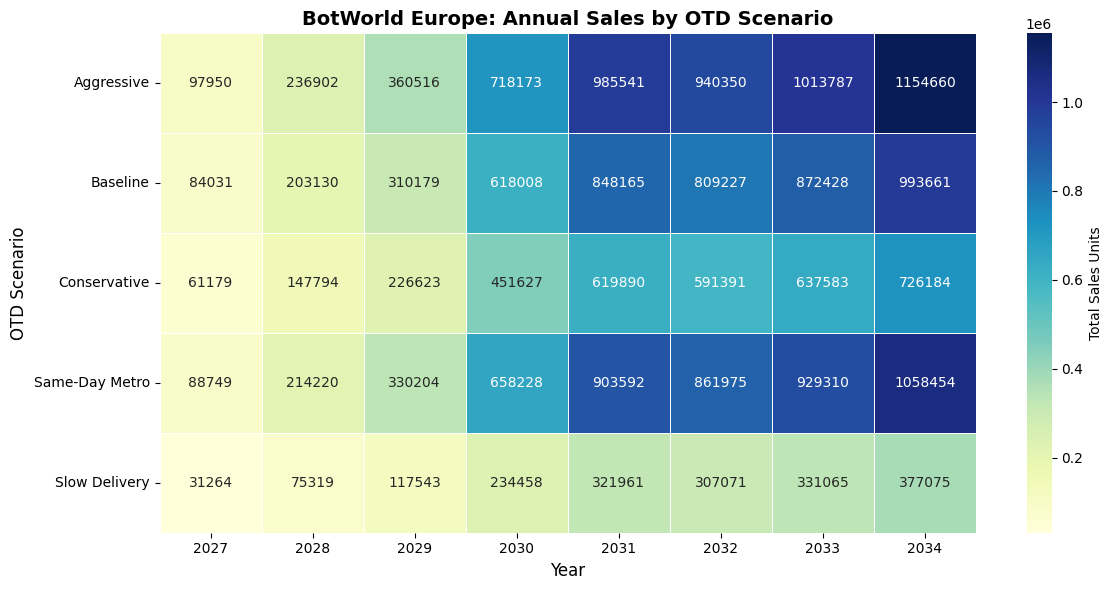

Saved: task6_heatmap_sales_by_scenario.png


In [16]:
fig, ax = plt.subplots(figsize=(12, 6))

heatmap_data = comparison_df.pivot_table(
    index='scenario',
    columns='year',
    values='sales_units',
    aggfunc='sum'
)

sns.heatmap(
    heatmap_data,
    annot=True,
    fmt='.0f',
    cmap='YlGnBu',
    linewidths=0.5,
    cbar_kws={'label': 'Total Sales Units'},
    ax=ax
)

ax.set_title('BotWorld Europe: Annual Sales by OTD Scenario', fontsize=14, fontweight='bold')
ax.set_xlabel('Year', fontsize=12)
ax.set_ylabel('OTD Scenario', fontsize=12)
plt.tight_layout()
plt.savefig('task6_heatmap_sales_by_scenario.png', dpi=150)
plt.show()
print('Saved: task6_heatmap_sales_by_scenario.png')

### 12.2 Heatmap: Conversion Rates by Scenario × Year

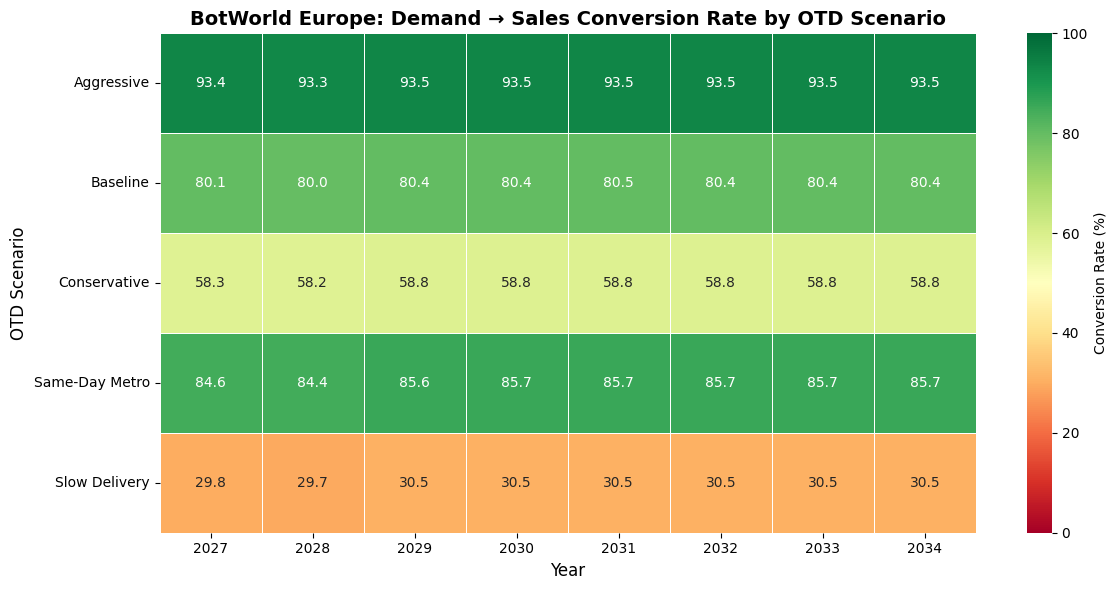

Saved: task6_heatmap_conversion_by_scenario.png


In [17]:
fig, ax = plt.subplots(figsize=(12, 6))

heatmap_conv = comparison_df.pivot_table(
    index='scenario',
    columns='year',
    values='conversion_pct',
    aggfunc='mean'
)

sns.heatmap(
    heatmap_conv,
    annot=True,
    fmt='.1f',
    cmap='RdYlGn',
    vmin=0,
    vmax=100,
    linewidths=0.5,
    cbar_kws={'label': 'Conversion Rate (%)'},
    ax=ax
)

ax.set_title('BotWorld Europe: Demand → Sales Conversion Rate by OTD Scenario', fontsize=14, fontweight='bold')
ax.set_xlabel('Year', fontsize=12)
ax.set_ylabel('OTD Scenario', fontsize=12)
plt.tight_layout()
plt.savefig('task6_heatmap_conversion_by_scenario.png', dpi=150)
plt.show()
print('Saved: task6_heatmap_conversion_by_scenario.png')

### 12.3 Time-Series: Daily Sales Comparison (2030)

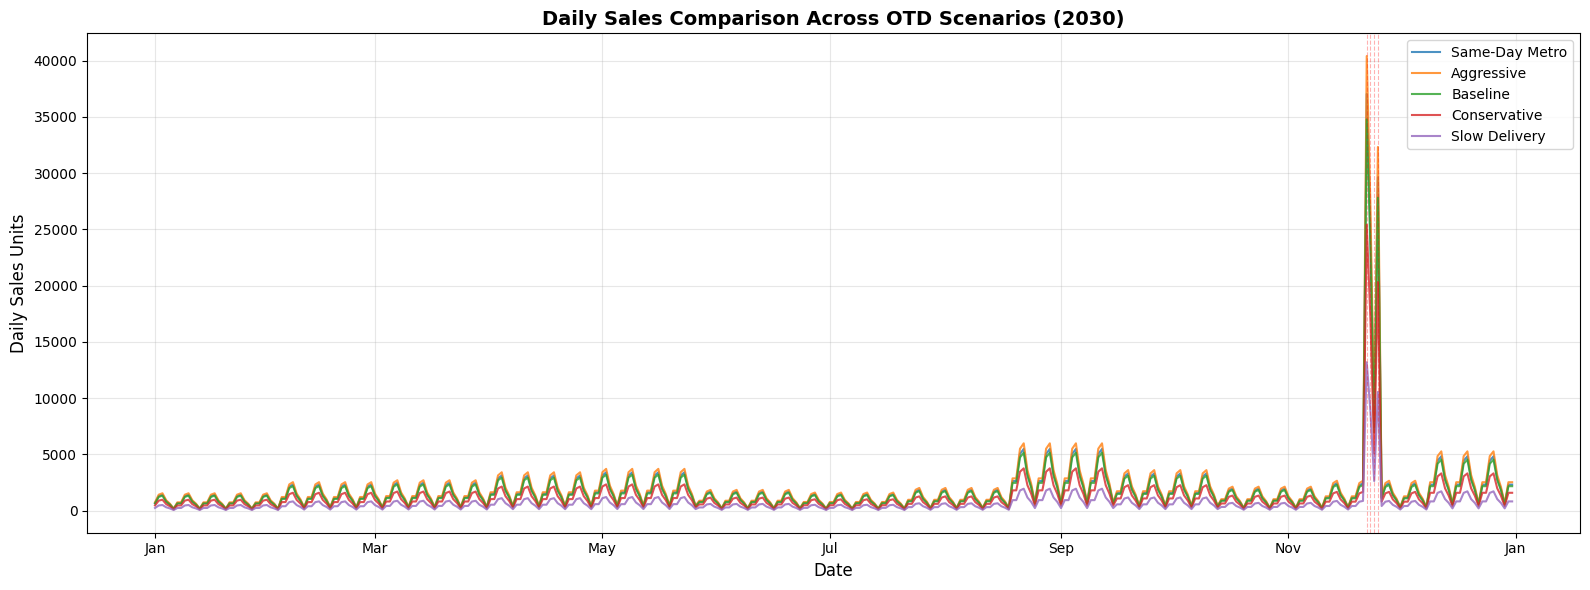

Saved: task6_timeseries_daily_sales_2030.png


In [18]:
# Daily sales comparison for 2030 across scenarios
fig, ax = plt.subplots(figsize=(16, 6))

colors_ts = ['#1f77b4', '#ff7f0e', '#2ca02c', '#d62728', '#9467bd']

for idx, (scenario_name, result_df) in enumerate(scenario_results.items()):
    daily_2030 = result_df[result_df['year'] == 2030].groupby('date')['sales_units'].sum().reset_index()
    ax.plot(
        daily_2030['date'],
        daily_2030['sales_units'],
        label=scenario_name,
        alpha=0.8,
        linewidth=1.5,
        color=colors_ts[idx]
    )

# Mark Cyber Week
cw = sorted(cyber_week_dates(2030))
for d in cw:
    ax.axvline(pd.Timestamp(d), color='red', alpha=0.3, linewidth=0.8, linestyle='--')

ax.set_title('Daily Sales Comparison Across OTD Scenarios (2030)', fontsize=14, fontweight='bold')
ax.set_xlabel('Date', fontsize=12)
ax.set_ylabel('Daily Sales Units', fontsize=12)
ax.legend(loc='upper right', fontsize=10)
ax.xaxis.set_major_formatter(mdates.DateFormatter('%b'))
ax.grid(True, alpha=0.3)
plt.tight_layout()
plt.savefig('task6_timeseries_daily_sales_2030.png', dpi=150)
plt.show()
print('Saved: task6_timeseries_daily_sales_2030.png')

### 12.4 Boxplot: Daily Sales Distribution by Scenario (2030)

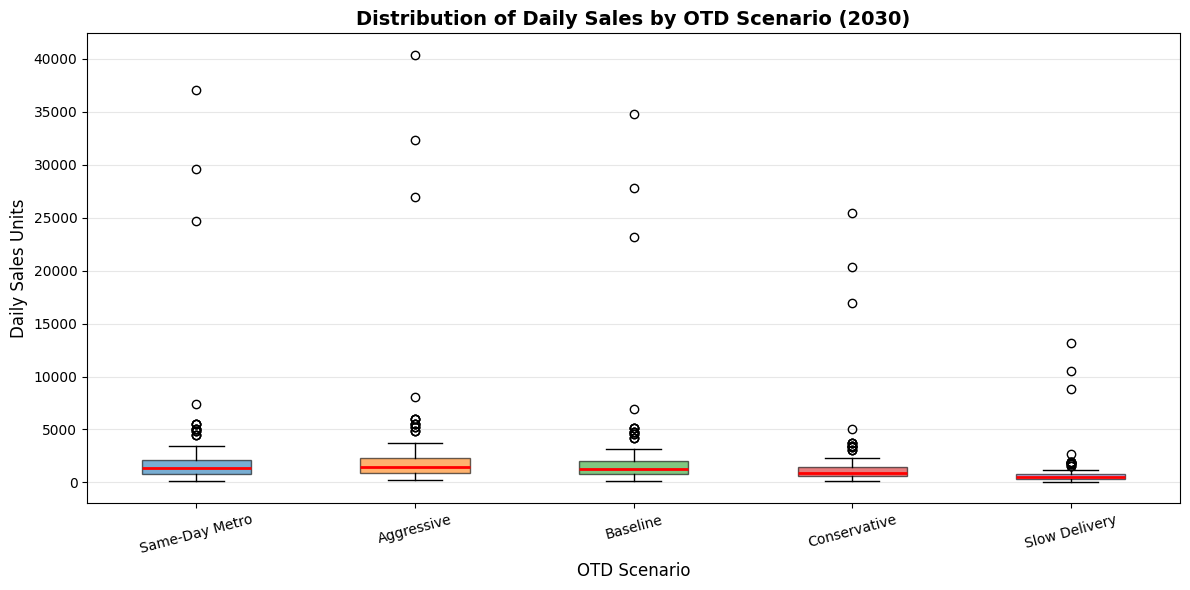

Saved: task6_boxplot_daily_sales_2030.png


In [19]:
fig, ax = plt.subplots(figsize=(12, 6))

boxplot_data = []
boxplot_labels = []

for scenario_name, result_df in scenario_results.items():
    daily_2030 = result_df[result_df['year'] == 2030].groupby('date')['sales_units'].sum()
    boxplot_data.append(daily_2030.values)
    boxplot_labels.append(scenario_name)

bp = ax.boxplot(
    boxplot_data,
    labels=boxplot_labels,
    patch_artist=True,
    medianprops=dict(color='red', linewidth=2)
)

for patch, color in zip(bp['boxes'], colors_ts):
    patch.set_facecolor(color)
    patch.set_alpha(0.6)

ax.set_title('Distribution of Daily Sales by OTD Scenario (2030)', fontsize=14, fontweight='bold')
ax.set_xlabel('OTD Scenario', fontsize=12)
ax.set_ylabel('Daily Sales Units', fontsize=12)
ax.grid(True, alpha=0.3, axis='y')
plt.xticks(rotation=15)
plt.tight_layout()
plt.savefig('task6_boxplot_daily_sales_2030.png', dpi=150)
plt.show()
print('Saved: task6_boxplot_daily_sales_2030.png')

### 12.5 Bar Chart: Annual Revenue Comparison by Scenario

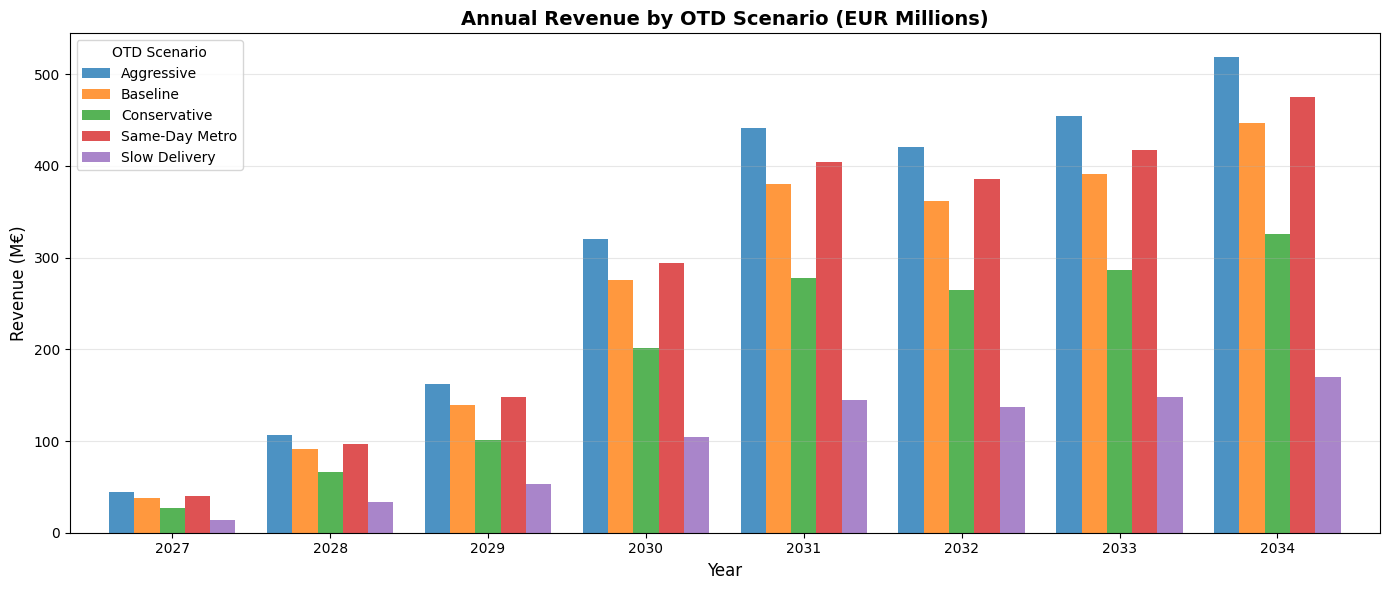

Saved: task6_barchart_revenue_by_scenario.png


In [20]:
fig, ax = plt.subplots(figsize=(14, 6))

revenue_pivot = comparison_df.pivot_table(
    index='year',
    columns='scenario',
    values='revenue',
    aggfunc='sum'
) / 1e6

revenue_pivot.plot(kind='bar', ax=ax, color=colors_ts, alpha=0.8, width=0.8)

ax.set_title('Annual Revenue by OTD Scenario (EUR Millions)', fontsize=14, fontweight='bold')
ax.set_xlabel('Year', fontsize=12)
ax.set_ylabel('Revenue (M€)', fontsize=12)
ax.legend(title='OTD Scenario', loc='upper left', fontsize=10)
ax.grid(True, alpha=0.3, axis='y')
plt.xticks(rotation=0)
plt.tight_layout()
plt.savefig('task6_barchart_revenue_by_scenario.png', dpi=150)
plt.show()
print('Saved: task6_barchart_revenue_by_scenario.png')

### 12.6 Lost Sales Analysis

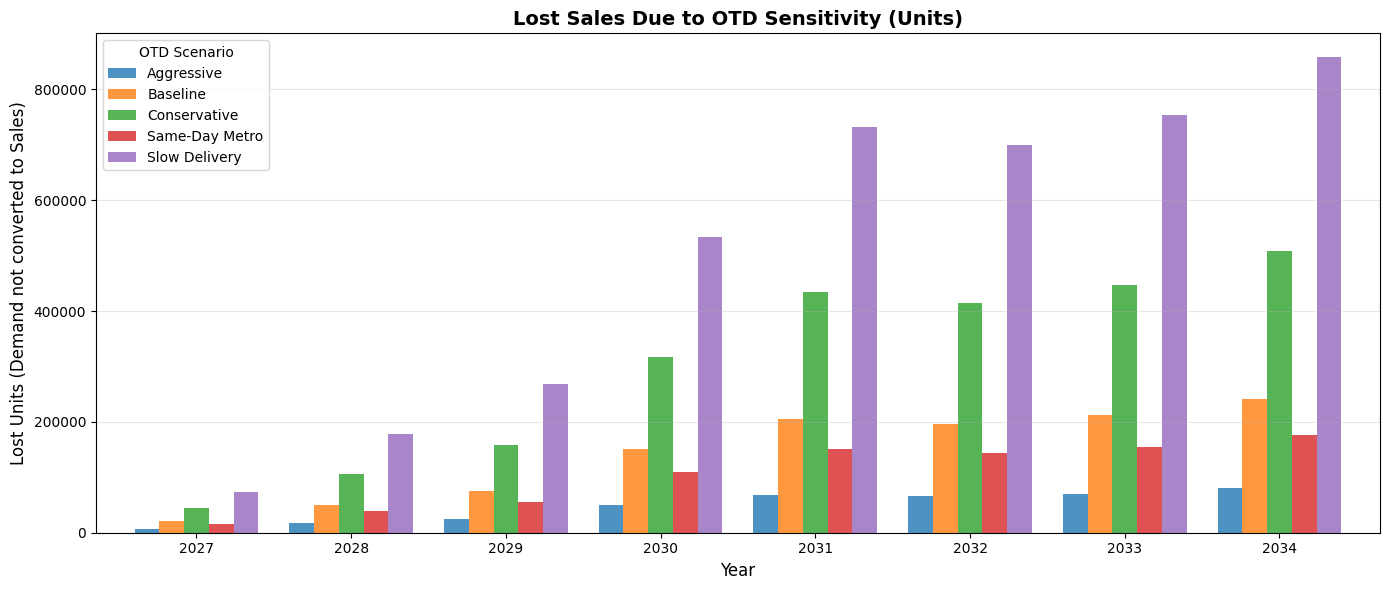

Saved: task6_lost_sales_by_scenario.png


In [21]:
fig, ax = plt.subplots(figsize=(14, 6))

lost_pivot = comparison_df.pivot_table(
    index='year',
    columns='scenario',
    values='lost_units',
    aggfunc='sum'
)

lost_pivot.plot(kind='bar', ax=ax, color=colors_ts, alpha=0.8, width=0.8)

ax.set_title('Lost Sales Due to OTD Sensitivity (Units)', fontsize=14, fontweight='bold')
ax.set_xlabel('Year', fontsize=12)
ax.set_ylabel('Lost Units (Demand not converted to Sales)', fontsize=12)
ax.legend(title='OTD Scenario', loc='upper left', fontsize=10)
ax.grid(True, alpha=0.3, axis='y')
plt.xticks(rotation=0)
plt.tight_layout()
plt.savefig('task6_lost_sales_by_scenario.png', dpi=150)
plt.show()
print('Saved: task6_lost_sales_by_scenario.png')